<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/header.png?raw=1" width="1000"/>


# Radar-based Flood Mapping

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/example.png?raw=1" width="1000"/>

***

The objective of this [Recommended Practice](https://un-spider.org/advisory-support/recommended-practices) is to determine the extent of flooded areas. The usage of Synthetic Aperture Radar (SAR) satellite imagery for flood extent mapping constitutes a viable solution with fast image processing, providing near real-time flood information to relief agencies for supporting humanitarian action. The high data reliability as well as the absence of geographical constraints, such as site accessibility, emphasize the technology’s potential in the field.

This Jupyter Notebook is optimized for the use with Google Colab. As a cloud computing-based environment, it takes advantage of external technical resources and thus allows this tool to be applied using devices with limited computing power, including phones and tablets, and in areas with scarce bandwidth.  
The notebook covers the full processing chain from data query and download up to the export of a final flood mask product by utilizing open access Sentinel-1 SAR data. The tool's workflow follows the UN-SPIDER Recommended Practice on [Radar-based Flood Mapping](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-radar-based-flood-mapping) and is illustrated in the chart below. After entering user specifications, Sentinel-1  data can directly be downloaded from the <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a>. Subsequently, the data is processed and stored in a variety of output formats.

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart0.png?raw=1" width="1000"/>

***

***File Structure***  
The Jupyter Notebook creates a folder called *'radar-based-flood-mapping'* in the Google Drive. Sentinel-1 images need to be stored in a subfolder called *'input'*. If no image is provided, the subfolder will automatically be created when accessing and downloading data from the <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a> through this tool. If an area of interest (AOI) file is available (supported formats: GeoJSON, SHP, KML, KMZ), it needs to be placed in a subfolder called *'AOI'*. If none are available, a dialogue will allow to manually draw and/or upload locally stored AOI files. For reasons of automatic file selection, it is recommended to place only one AOI file in the respective folder. However, if multiple files exist, GeoJSON files are prioritized followed by SHP, KML, and KMZ. The processed data is stored in a subfolder called *'output'*.  
In order to run the tool with no user interaction, all inputs must be clearly defined. This means that the *'input'* subfolder must include one single Sentinel-1 image and the *'AOI'* subfolder one single AOI file. All other scenarios do require manual interaction such as downloading data or defining an AOI.

***Limitations***  
Difficulties in detecting flooded vegetation and floods in urban areas due to double bounce backscatter. If water and non-water are very unequally distributed in the image, the histogram might not have a clear local minimum, leading to incorrect results in the automatic binarization process.

***

## Initialization

The Jupyter Notebook takes advantage of the <a href="https://step.esa.int/docs/v6.0/apidoc/engine/">ESA SNAP API Engine</a> using the SNAP-Python interface <i>snappy</i>. The installation and configuration procedure is included in the initialization step of this tool which consequently might take a few minutes during the initial run of this Jupyter Notebook.

In [1]:
#@title <font color=#1B7192> Click to run </font>  { display-mode: "form" }

#####################################################
################### CONFIGURATION ###################
#####################################################

# mounnt Google Drive
import os                                     # data access
import google.colab                           # Google Colab
import time                                   # time assessment
import sys
if not os.path.isdir('/content/drive'):
    google.colab.drive.mount('/content/drive')

try:
    import snappy                             # SNAP Python interface
    import jpy                                # Python-Java bridge
except:
    with google.colab.output.use_tags('snappy'):
        sys.stdout.write('\nPreparing conda environment...\n')
        sys.stdout.flush()
        !pip install -q condacolab &> /dev/null
        import condacolab
        condacolab.install_miniconda()
        sys.stdout.write('\nInstalling snappy package...\n')
        sys.stdout.flush()
        !conda install -c terradue -c conda-forge snap=8.0.0 &> /dev/null
    google.colab.output.clear(output_tags='snappy')
try:
    import geopandas                          # data analysis and manipulation
except:
    with google.colab.output.use_tags('geopandas'):
        sys.stdout.write('\nInstalling geopandas package...\n')
        sys.stdout.flush()
        !pip install geopandas &> /dev/null
    google.colab.output.clear(output_tags='geopandas')
try:
    from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt  # interface to Open Access Hub
except:
    with google.colab.output.use_tags('sentinelsat'):
        sys.stdout.write('\nInstalling sentinelsat package...\n')
        sys.stdout.flush()
        !pip install sentinelsat &> /dev/null
    google.colab.output.clear(output_tags='sentinelsat')
try:
    from ipyfilechooser import FileChooser    # file chooser widget
except:
    with google.colab.output.use_tags('ipyfilechooser'):
        sys.stdout.write('\nInstalling ipyfilechooser package...\n')
        sys.stdout.flush()
        !pip install ipyfilechooser &> /dev/null
    google.colab.output.clear(output_tags='ipyfilechooser')

# status update
with google.colab.output.use_tags('initialization'):
    sys.stdout.write('\nInitialization successful!')
    sys.stdout.flush()
time.sleep(1)
google.colab.output.clear(output_tags='initialization')

Mounted at /content/drive


## User Input

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart1.png?raw=1" width="1000"/>

Please specify in the code cell below i) the polarisation to be processed, ii) whether data shall be downloaded from the <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a>, and iii) whether intermediate results should be plotted during the process. This section also loads relevant Python modules for the following analysis and initializes basic functionalities.

In [14]:
#@title <font color=#1B7192> Click to run </font>  { display-mode: "form" }

####################################################
#################### USER INPUT ####################
####################################################

# polarisations to be processed
Polarisation  = 'both'                    #@param ["VH", "VV", "both"]

DownloadImage = True                   #@param {type:"boolean"}

# show intermediate results if set to 'True'
PlotResults   = True                    #@param {type:"boolean"}

#####################################################
###################### IMPORTS ######################
#####################################################

# MODULE                                      # DESCRIPTION
import sys
try:
    import snappy                         # SNAP Python interface
    import jpy                            # Python-Java bridge
    import geopandas                          # data analysis and manipulation
    from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt  # interface to Open Access Hub
    from ipyfilechooser import FileChooser    # file chooser widget
except:
    sys.exit('\nPlease run initialization cell above first.')
import os                                     # data access
import google.colab                           # Google Colab
import matplotlib.pyplot as plt               # create visualizations
import numpy as np                            # scientific comupting
import json                                   # JSON encoder and decoder
import glob                                   # data access
import ipywidgets                             # interactive UI controls
import time                                   # time assessment
import shutil                                 # file operations
import folium                                 # visualization
from folium import plugins                    # visualization
from folium.plugins import MiniMap, Draw, Search # visualization
import skimage.filters                        # threshold calculation
import functools                              # higher-order functions and operations
from datetime import date                     # dates, times and intervalls
from IPython.display import display           # visualization
from osgeo import ogr, gdal, osr              # data conversion
from zipfile import ZipFile                   # file management




####################################################
############### FUNCTION DEFINITIONS ###############
####################################################

def getAOI(path):
    try:
        file = readJSONFromAOI(path)
    except:
        print('No AOI file was found. Please draw and download the area of interest by clicking the Export-button')
        print('inside the map or directly upload a locally stored AOI file using the dialogue below the map.\n')
        # create map
        f = folium.Figure(height=500)
        m = folium.Map(location=[0, 0], zoom_start=2.5, control_scale=True).add_to(f)
        # add custom basemap
        basemaps['Google Satellite Hybrid'].add_to(m)
        # add a layer control panel to the map
        m.add_child(folium.LayerControl())
        # add minimap
        m.add_child(MiniMap(tile_layer=basemaps['Google Satellite'], position='bottomright'))
        # add draw control
        draw = Draw(export=True, filename='AOI_manual_%s.geojson' % str(date.today()), draw_options={'polyline': False, 'circle': False, 'marker': False, 'circlemarker': False})
        draw.add_to(m)
        # display map
        updater = display(f, display_id='m')
        print('\n')
        # open upload section
        os.chdir('/content')
        uploaded = google.colab.files.upload()
        for fn in uploaded.keys():
            # copy uploaded file to GDrive folder
            aoi_path = os.path.join(directory, 'AOI')
            if not os.path.isdir(aoi_path):
                os.mkdir(aoi_path)
            shutil.copy2('/content/%s' % fn, aoi_path)
            # remove original file
            os.remove('/content/%s' % fn)
            file_path = '%s/%s' % (aoi_path, fn)
        file = readJSONFromAOI(aoi_path)
    
    return file



# Function looks for AOI file, converts to GeoJSON if not given and returns path to GeoJSON
def readJSONFromAOI(path):
    # check for GeoJSON file in 'AOI' subfolder
    if len(glob.glob('%s/*.geojson' % path)) == 1:
        file = glob.glob('%s/*.geojson' % path)[0]
    elif len(glob.glob('%s/*.json' % path)) == 1:
        file = glob.glob('%s/*.json' % path)[0]

    # convert SHP to GeoJSON if no JSON is given
    elif len(glob.glob('%s/*.shp' % path)) == 1:
        file_name = os.path.splitext(glob.glob('%s/*.shp' % path)[0])[0].split('/')[-1]
        shp_file = geopandas.read_file(glob.glob('%s/*.shp' % path)[0])
        shp_file.to_file('%s/%s.json' % (path, file_name), driver='GeoJSON')
        file = glob.glob('%s/*.json' % path)[0]

    # convert KML to GeoJSON if no JSON or SHP is given
    elif len(glob.glob('%s/*.kml' % path)) == 1:
        file_name = os.path.splitext(glob.glob('%s/*.kml' % path)[0])[0].split('/')[-1]
        kml_file = gdal.OpenEx(glob.glob('%s/*.kml' % path)[0])
        ds = gdal.VectorTranslate('%s/%s.json' % (path, file_name), kml_file, format='GeoJSON')
        del ds
        file = glob.glob('%s/*.json' % path)[0]

    # convert KMZ to JSON if no JSON, SHP, or KML is given
    elif len(glob.glob('%s/*.kmz' % path)) == 1:
        # open KMZ file and extract data
        with ZipFile(glob.glob('%s/*.kmz' % path)[0], 'r') as kmz:
            folder = os.path.splitext(glob.glob('%s/*.kmz' % path)[0])[0]
            kmz.extractall(folder)
        # convert KML to GeoJSON if extracted folder contains one KML file
        if len(glob.glob('%s/*.kml' % folder)) == 1:
            kml_file = gdal.OpenEx(glob.glob('%s/*.kml' % folder)[0])
            ds = gdal.VectorTranslate('%s/%s.json' % (path, folder.split('/')[-1]), kml_file, format='GeoJSON')
            del ds
            file = glob.glob('%s/*.json' % path)[0]
            # remove unzipped KMZ directory and data
            shutil.rmtree(folder)
    # allow to upload AOI file or manually draw AOI if no file was found
    else:
        raise FileNotFoundError

    return file


# plot band and histogram of 'Band'-type input and threshold
# SNAP API: https://step.esa.int/docs/v6.0/apidoc/engine/
def plotBand(band, threshold, binary=False):
    # color stretch
    vmin, vmax = 0, 1
    # read pixel values
    w = band.getRasterWidth()
    h = band.getRasterHeight()
    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)
    band_data.shape = h, w
    # color stretch
    if binary:
        cmap = plt.get_cmap('binary')
    else:
        vmin = np.percentile(band_data, 2.5)
        vmax = np.percentile(band_data, 97.5)
        cmap = plt.get_cmap('gray')
    # plot band
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    ax1.imshow(band_data, cmap=cmap, vmin=vmin, vmax=vmax)
    ax1.set_title(band.getName())
    # plot histogram
    band_data.shape = h * w 
    ax2.hist(np.asarray(band_data[band_data != 0], dtype='float'), bins=2048)
    ax2.axvline(x=threshold, color='r')
    ax2.set_title('Histogram: %s' % band.getName())
    
    for ax in fig.get_axes():
        ax.label_outer()




####################################################
####################### CODE #######################
####################################################   
        
# set working directory
directory = '/content/drive/MyDrive/radar-based-flood-mapping'
if not os.path.isdir(directory):
    os.mkdir(directory)

# Add custom basemap to folium
basemaps = {
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True,
        show = False
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True,
        show = False
    )
}

## Download Image

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart2.png?raw=1" width="1000"/>

This section allows interactive data access and download from the <a href="https://scihub.copernicus.eu/">Copernicus Open Access Hub</a>. It requires respective login details and the desired sensing period. If an AOI file is given in the *'AOI'* subfolder, the tool searches and displays available Sentinel-1 images accordingly. If no AOI file is provided, an interactive map allows to draw and download the area of interest by clicking the *'Export'*-button inside the map or to directly upload a locally stored AOI file. When hovering over a Sentinel-1 image, the tile index and ingestion dates are shown. The table below summarizes information on all available tiles and allows the download. The data is stored in the automatically created *'input'* subfolder. The Open Access Hub maintains an online archive of at least the latest year of products for immediate download. Access to previous products that are no longer available online will automatically trigger the retrieval from the long term archives. The actual download can be initiated by the user once the data are restored (within 24 hours).

In [15]:
#@title <font color=#1B7192> Click to run </font>  { display-mode: "form" }

####################################################
#################### USER INPUT ####################
####################################################

Username      = '1kaiser'              #@param {type:"string"}
Password      = 'hV@dkL4x7yTkzp+'              #@param {type:"string"}
SensingPeriod_Start  = '2022-10-01'     #@param {type:"date"}
SensingPeriod_Stop   = '2022-10-08'     #@param {type:"date"}




####################################################
############### FUNCTION DEFINITIONS ###############
####################################################

# search for and display available Sentinel-1 tiles
def queri(footprint):
    # print status
    with google.colab.output.use_tags('loading'):
        sys.stdout.write('\nLoading...')
        sys.stdout.flush()
    # search Copernicus Open Access Hub for products with regard to input footprint and sensing period
    period = (date(int(SensingPeriod_Start.split('-')[0]), int(SensingPeriod_Start.split('-')[1]), int(SensingPeriod_Start.split('-')[2])),
              date(int(SensingPeriod_Stop.split('-')[0]), int(SensingPeriod_Stop.split('-')[1]), int(SensingPeriod_Stop.split('-')[2])))
    try:
        products = api.query(footprint, date=period, platformname='Sentinel-1', producttype='GRD')
        print('Successfully connected to Copernicus Open Access Hub.\n', flush=True)
    except:
        sys.exit('\nLogin data not valid. Please change username and/or password.')
    # convert to GeoJSON for plot
    products_json = api.to_geojson(products)
    # raise warning that no image is available in given sensing period
    if not products_json['features']:
        sys.exit('\nNo Sentinel-1 images available. Please change sensing period in user input section.')
    # convert to dataframe for table visualization
    products_df = api.to_dataframe(products)
    # adds index to dataframe
    indices = []
    for i in range (1, len(products_df.index)+1):
        indices.append('Tile %d' % i)
        products_json.features[i-1].properties['index'] = ' Tile %d' % i
    products_df.insert(0, 'index', indices, True) 

    # load products in folium framework for visualization
    s1_tiles = folium.GeoJson(
        products_json,
        name='S1 tiles',
        show=True,
        style_function=lambda feature: {'fillColor': 'royalblue', 'fillOpacity' : 0.2},
        highlight_function=lambda x: {'fillOpacity' : 0.4},
        tooltip=folium.features.GeoJsonTooltip(
            fields=['index', 'beginposition'],
            aliases=['Index:','Date:'],
        ),
    ).add_to(m)
    # add custom basemap
    basemaps['Google Satellite Hybrid'].add_to(m)
    # add a layer control panel to the map
    m.add_child(folium.LayerControl())
    # clear status update
    #google.colab.output.clear(output_tags='loading')
    # update map
    updater.update(m)

    # print table with download buttons
    grid = ipywidgets.GridspecLayout(len(products_df.index)+1, 5)
    grid[0,0] = ipywidgets.HTML('<h3>Index</h3>')
    grid[0,1] = ipywidgets.HTML('<h3>Date</h3>')
    grid[0,2] = ipywidgets.HTML('<h3>Polarisation</h3>')
    grid[0,3] = ipywidgets.HTML('<h3>Size</h3>')
    for i in range(len(products_df.index)):
        grid[i+1,0] = ipywidgets.Label(products_df['index'][i])
        grid[i+1,1] = ipywidgets.Label(str(products_df['beginposition'][i]))
        grid[i+1,2] = ipywidgets.Label(products_df['polarisationmode'][i])
        grid[i+1,3] = ipywidgets.Label(products_df['size'][i])
        grid[i+1,4] = ipywidgets.Button(description = 'Download')
        print(products_df.values[i][-1])
        grid[i+1,4].on_click(functools.partial(on_downloadButton_clicked, tile_id=products_df.values[i][-1]))
    print(grid)


# download chosen Sentinel-1 tile in subfolder 'input'
def on_downloadButton_clicked(b, tile_id):
    from google.colab import output
    output.enable_custom_widget_manager()
    # get product information
    product_info = api.get_product_odata(tile_id)
    # check whether product is available
    if product_info['Online']:
        # check if input folder exists, if not create input folder
        input_path = os.path.join(directory, 'input')
        if not os.path.isdir(input_path):
            os.mkdir(input_path)
        # change into 'input' subfolder for storing product
        os.chdir(input_path)
        # status update
        print('\nProduct %s is online. Starting download.' % tile_id, flush=True)
        # download product
        api.download(tile_id)
        # change back to previous working directory
        os.chdir(directory)
    # error message when product is not available
    else:
        print('\nProduct %s is not online. Must be requested manually.\n' % tile_id, flush=True)




####################################################
####################### CODE #######################
####################################################

# check user input whether image download is requested
if DownloadImage:
    # connect to the API
    api = SentinelAPI(Username, Password, 'https://scihub.copernicus.eu/dhus')
    # get path to AOI
    file = getAOI('%s/AOI' % directory)
    # open AOI GeoJSON file and store data
    with open(file, 'r') as f:
        data_json = json.load(f)
    # define map center depending on GeoJSON internal structure
    try:
        # GeoJSON format if KMZ is given
        center = [data_json['features'][0]['geometry']['coordinates'][0][0][0][1],
                  data_json['features'][0]['geometry']['coordinates'][0][0][0][0]]
    except:
        # GeoJSON format if JSON or SHP is given
        center = [data_json['features'][0]['geometry']['coordinates'][0][0][1],
                  data_json['features'][0]['geometry']['coordinates'][0][0][0]]
    # create map
    f = folium.Figure(height=500)
    m = folium.Map(location=center, zoom_start=6, control_scale=True).add_to(f)
    # add AOI to map
    folium.GeoJson(file, name='AOI', style_function = lambda x: {'color':'green'}).add_to(m)
    footprint = geojson_to_wkt(data_json)
    updater = display(f, display_id='m')

    # search for available Sentinel-1 tiles
    queri(footprint)


Loading...

Successfully connected to Copernicus Open Access Hub.

2f596dca-9ae3-4a0d-ae90-37e7445fc828
3791ff0f-f880-413b-a069-67bd38c3ad9d
30247461-0c84-4e7c-9cc2-6f1bc1745e3d
c5d7b60d-56ce-4407-b5c8-36c793d27d3d
fda9e5f6-bc31-490f-8f46-84a7f2a49283
0e83268c-35e7-4fd1-95e7-32315e863508
41ee6424-7944-400c-bafe-42d8323259bd
e235d5f8-0228-412a-a733-8c0603313330
GridspecLayout(children=(HTML(value='<h3>Index</h3>', layout=Layout(grid_area='widget001')), HTML(value='<h3>Date</h3>', layout=Layout(grid_area='widget002')), HTML(value='<h3>Polarisation</h3>', layout=Layout(grid_area='widget003')), HTML(value='<h3>Size</h3>', layout=Layout(grid_area='widget004')), Label(value='Tile 1', layout=Layout(grid_area='widget005')), Label(value='2022-10-06 13:04:53.170000', layout=Layout(grid_area='widget006')), Label(value='VV VH', layout=Layout(grid_area='widget007')), Label(value='1.6 GB', layout=Layout(grid_area='widget008')), Button(description='Download', layout=Layout(grid_area='widget009'), style=ButtonSty

In [17]:
tile_id = '3791ff0f-f880-413b-a069-67bd38c3ad9d'
product_info = api.get_product_odata(tile_id)
  # check whether product is available
if product_info['Online']:
    # check if input folder exists, if not create input folder
    input_path = os.path.join(directory, 'input')
    if not os.path.isdir(input_path):
        os.mkdir(input_path)
    # change into 'input' subfolder for storing product
    os.chdir(input_path)
    # status update
    print('\nProduct %s is online. Starting download.' % tile_id, flush=True)
    # download product
    api.download(tile_id)
    # change back to previous working directory
    print("🔻complete🔻")
    os.chdir(directory)
# error message when product is not available
else:
    print('\nProduct %s is not online. Must be requested manually.\n' % tile_id, flush=True)



Product 3791ff0f-f880-413b-a069-67bd38c3ad9d is online. Starting download.


MD5 checksumming:   0%|          | 0.00/991M [00:00<?, ?B/s]

🔻complete🔻


## Processing

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart3.png?raw=1" width="1000"/>

If more than one Sentinel-1 image exists in the *'input'* subfolder, the user can select which one is to be used for the processing. The subset is generated according to the AOI file in the *'AOI'* subfolder. If no AOI file is provided, an interactive map allows to draw and download the area of interest by clicking the *'Export'*-button inside the map or to directly upload a locally stored AOI file. Subsequently, the following processing steps are performed:

1. ***Apply Orbit File***: The orbit file provides accurate satellite position and velocity information. Based on this information, the orbit state vectors in the abstract metadata of the product are updated. The precise orbit files are available days-to-weeks after the generation of the product. Since this is an optional processing step, the tool will continue the workflow in case the orbit file is not yet available to allow rapid mapping applications.


2. ***Thermal Noise Removal***: Thermal noise correction is applied to Sentinel-1 Level-1 GRD products which have not already been corrected.


3. ***Radiometric Calibration***: The objective of SAR calibration is to provide imagery in which the pixel values can be directly related to the radar backscatter of the scene. Though uncalibrated SAR imagery is sufficient for qualitative use, calibrated SAR images are essential to the quantitative use of SAR data.


4. ***Speckle Filtering***: SAR images have inherent texturing called speckles which degrade the quality of the image and make interpretation of features more difficult. Speckles are caused by random constructive and destructive interference of the de-phased but coherent return waves scattered by the elementary scatter within each resolution cell. Speckle noise reduction can be applied either by spatial filtering or multilook processing. A Lee filter with an X, Y size of 5, 5 is used in this step.


5. ***Terrain Correction***: Due to topographical variations of a scene and the tilt of the satellite sensor, distances can be distorted in the SAR images. Data which is not directly directed towards the sensor’s Nadir location will have some distortion. Therefore, terrain corrections are intended to compensate for these distortions to allow a realistic geometric representation in the image.


6. ***Binarization***: In order to obtain a binary flood mask, the histogram is analyzed to separate water from non-water pixels. Due to the side-looking geometry of SAR sensors and the comparably smooth surface of water, only a very small proportion of backscatter is reflected back to the sensor leading to comparably low pixel values in the histogram. The threshold used for separation is automatically calculated using <a href="https://scikit-image.org/">scikit-image</a> implementations and a combined use of the <a href="https://doi.org/10.1111/j.1749-6632.1965.tb11715.x">minimum method</a> and <a href="https://www.semanticscholar.org/paper/A-threshold-selection-method-from-gray-level-Otsu/1d4816c612e38dac86f2149af667a5581686cdef?p2df">Otsu's method</a>. The <a href="http://due.esrin.esa.int/page_globcover.php">GlobCover</a> layer of the European Space Agency is used to mask out permanent water bodies.


7. ***Speckle Filtering***: A Median filter with an X, Y size of 7, 7 is used in this step.

Selected:  S1A_IW_GRDH_1SDV_20221006T130428_20221006T130453_045322_056B27_C5B2.zip




Subset successfully generated.

1. Apply Orbit File:          --- 6.14  seconds ---
2. Thermal Noise Removal:     --- 0.06  seconds ---
3. Radiometric Calibration:   --- 0.13  seconds ---
4. Speckle Filtering:         --- 0.03  seconds ---
5. Terrain Correction:        --- 0.26  seconds ---
6. Binarization:              --- 38.30 seconds ---
7. Speckle Filtering:         --- 0.03  seconds ---
8. Plot:                      --- 81.56 seconds ---


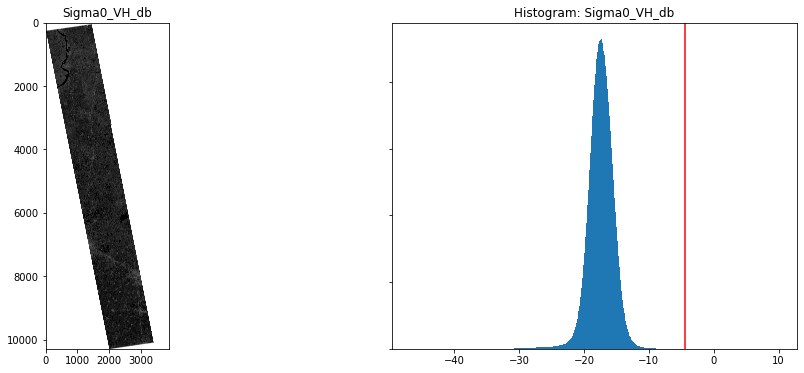

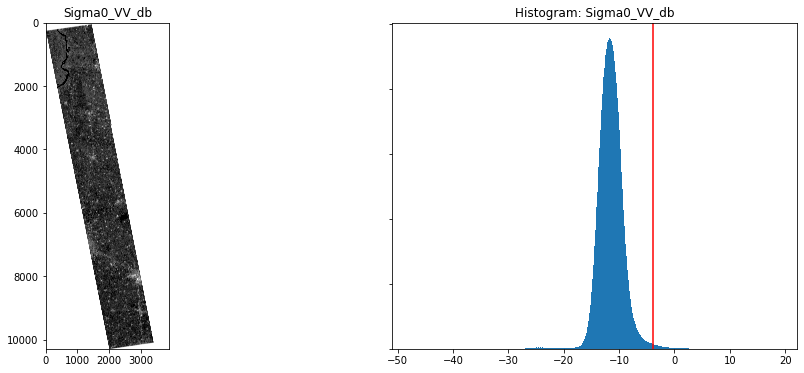

In [18]:
#@title <font color=#1B7192> Click to run </font>  { display-mode: "form" }

####################################################
############### FUNCTION DEFINITIONS ###############
####################################################

def applySubset(path):
    # set correct path of input file and create S1 product
    if len(files) == 1:
        file_path = path
    else:
        file_path = path.selected
    S1_source = snappy.ProductIO.readProduct(file_path)

    # read geographic coordinates from Sentinel-1 image meta data
    meta_data = S1_source.getMetadataRoot().getElement('Abstracted_Metadata')
    # refines center of map according to Sentinel-1 image
    S1_center = (meta_data.getAttributeDouble('centre_lat'), meta_data.getAttributeDouble('centre_lon'))
    # defines polygon illustrating Sentinel-1 image
    polygon_geom = {
      "type": "FeatureCollection",
      "features":
                [{"type": "Feature",
                "properties": {},
                "geometry": {"type": "Polygon", "coordinates": [[[meta_data.getAttributeDouble('first_near_long'), meta_data.getAttributeDouble('first_near_lat')],
                                                                [meta_data.getAttributeDouble('last_near_long'), meta_data.getAttributeDouble('last_near_lat')],
                                                                [meta_data.getAttributeDouble('last_far_long'), meta_data.getAttributeDouble('last_far_lat')],
                                                                [meta_data.getAttributeDouble('first_far_long'), meta_data.getAttributeDouble('first_far_lat')],
                                                                [meta_data.getAttributeDouble('first_near_long'), meta_data.getAttributeDouble('first_near_lat')]]]}}]}

    # get path to AOI
    file = getAOI('%s/AOI' % directory)
    # open GeoJSON file and store data
    with open(file, 'r') as f:
        data_json = json.load(f)
    footprint = geojson_to_wkt(data_json)

    # creates map
    f = folium.Figure(height=500)
    m = folium.Map(location = S1_center, zoom_start = 7.5, control_scale=True).add_to(f)
    # add S1 tile to map
    folium.GeoJson(polygon_geom, name='Sentinel-1 tile').add_to(m)
    # add AOI to map
    folium.GeoJson(file, name='AOI', style_function = lambda x: {'color':'green'}).add_to(m)
    # add custom basemap
    basemaps['Google Satellite Hybrid'].add_to(m)
    # add a layer control panel to the map
    m.add_child(folium.LayerControl())
    # display map
    updater = display(f, display_id='m')

    # Subset operator
    parameters = snappy.HashMap()
    parameters.put('copyMetadata', True)
    geom = snappy.WKTReader().read(footprint)
    parameters.put('geoRegion', geom)
    parameters.put('sourceBands', sourceBands)
    S1_crop = snappy.GPF.createProduct('Subset', parameters, S1_source)
    # status update
    print('\nSubset successfully generated.\n', flush=True)

    # run processing process
    processing(S1_crop)


# calculate and return threshold of 'Band'-type input
# SNAP API: https://step.esa.int/docs/v6.0/apidoc/engine/
def getThreshold(S1_band):
    # read band
    w = S1_band.getRasterWidth()
    h = S1_band.getRasterHeight()
    band_data = np.zeros(w * h, np.float32)
    S1_band.readPixels(0, 0, w, h, band_data)
    band_data.shape = h * w
    # calculate threshold using Otsu method
    threshold_otsu = skimage.filters.threshold_otsu(band_data)
    # calculate threshold using minimum method
    threshold_minimum = skimage.filters.threshold_minimum(band_data)
    # get number of pixels for both thresholds
    numPixOtsu = len(band_data[abs(band_data - threshold_otsu) < 0.1])
    numPixMinimum = len(band_data[abs(band_data - threshold_minimum) < 0.1])

    # if number of pixels at minimum threshold is less than 0.1% of number of pixels at Otsu threshold
    if abs(numPixMinimum/numPixOtsu) < 0.001:
        # adjust band data according
        if threshold_otsu < threshold_minimum:
            band_data = band_data[band_data < threshold_minimum]
            threshold_minimum = skimage.filters.threshold_minimum(band_data)
        else:
            band_data = band_data[band_data > threshold_minimum]
            threshold_minimum = skimage.filters.threshold_minimum(band_data)
        numPixMinimum = len(band_data[abs(band_data - threshold_minimum) < 0.1])
    # check for final threshold
    if abs(numPixMinimum/numPixOtsu) < 0.001:
        threshold = threshold_otsu
    else:
        threshold = threshold_minimum

    return threshold


# calculate binary mask of 'Product'-type intput with respect expression in string array
def binarization(S1_product, expressions):

    BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')
    targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', len(expressions))

    # loop through bands
    for i in range(len(expressions)):
        targetBand = BandDescriptor()
        targetBand.name = '%s' % S1_product.getBandNames()[i]
        targetBand.type = 'float32'
        targetBand.expression = expressions[i]
        targetBands[i] = targetBand
    
    parameters = snappy.HashMap()
    parameters.put('targetBands', targetBands)    
    mask = snappy.GPF.createProduct('BandMaths', parameters, S1_product)

    return mask


# processing steps
def processing(S1_crop):
    # Apply-Orbit-File operator
    print('1. Apply Orbit File:          ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    # continue with calculation in case no orbit file is available yet
    parameters.put('continueOnFail', True)
    S1_Orb = snappy.GPF.createProduct('Apply-Orbit-File', parameters, S1_crop)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # ThermalNoiseRemoval operator
    print('2. Thermal Noise Removal:     ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    parameters.put('removeThermalNoise', True)
    S1_Thm = snappy.GPF.createProduct('ThermalNoiseRemoval', parameters, S1_Orb)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # Calibration operator
    print('3. Radiometric Calibration:   ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    parameters.put('outputSigmaBand', True)
    S1_Cal = snappy.GPF.createProduct('Calibration', parameters, S1_Thm)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # Speckle-Filter operator
    print('4. Speckle Filtering:         ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    parameters.put('filter', 'Lee')
    parameters.put('filterSizeX', 5)
    parameters.put('filterSizeY', 5)
    S1_Spk = snappy.GPF.createProduct('Speckle-Filter', parameters, S1_Cal)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # Conversion from linear to db operator
    S1_Spk_db = snappy.GPF.createProduct('LinearToFromdB', snappy.HashMap(), S1_Spk)

    # Terrain-Correction operator
    print('5. Terrain Correction:        ', end='', flush=True)
    parameters = snappy.HashMap()
    parameters.put('demName', 'SRTM 1Sec HGT')
    parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION')
    parameters.put('imgResamplingMethod', 'NEAREST_NEIGHBOUR')
    parameters.put('pixelSpacingInMeter', 10.0)
    parameters.put('nodataValueAtSea', False)
    parameters.put('saveSelectedSourceBand', True)
    S1_TC = snappy.GPF.createProduct('Terrain-Correction', parameters, S1_Spk_db)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # Binarization
    print('6. Binarization:              ', end='', flush=True)
    start_time = time.time()
    # add GlobCover band
    parameters = snappy.HashMap()
    parameters.put('landCoverNames', 'GlobCover')
    GlobCover = snappy.GPF.createProduct('AddLandCover', parameters, S1_TC)
    # empty string array for binarization band maths expression(s)
    expressions = ['' for i in range(S1_TC.getNumBands())]
    # empty array for threshold(s)
    thresholds = np.zeros(S1_TC.getNumBands())
    # loop through bands
    for i in range(S1_TC.getNumBands()):
        # calculate threshold of band and store in float array
        # use S1_Spk_db product for performance reasons. S1_TC causes 0-values
        # which distort histogram and thus threshold result
        thresholds[i] = getThreshold(S1_Spk_db.getBandAt(i))
        # formulate expression according to threshold and store in string array
        expressions[i] = 'if (%s < %s && land_cover_GlobCover != 210) then 1 else NaN' % (S1_TC.getBandNames()[i], thresholds[i])
    # do binarization
    S1_floodMask = binarization(GlobCover, expressions)
    print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)

    # Speckle-Filter operator
    print('7. Speckle Filtering:         ', end='', flush=True)
    start_time = time.time()
    parameters = snappy.HashMap()
    parameters.put('filter', 'Median')
    parameters.put('filterSizeX', 5)
    parameters.put('filterSizeY', 5)
    # define flood mask as global for later access
    global S1_floodMask_Spk
    S1_floodMask_Spk = snappy.GPF.createProduct('Speckle-Filter', parameters, S1_floodMask)
    print('--- %.2f  seconds ---' % (time.time() - start_time), flush=True)

    # output
    if PlotResults:
        print('8. Plot:                      ', end='', flush=True)
        start_time = time.time()
        for i in range(S1_TC.getNumBands()):
            plotBand(S1_TC.getBandAt(i), thresholds[i])
        print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)




####################################################
####################### CODE #######################
####################################################

# filter required polarisation(s) and set output file name accordingly
if Polarisation == 'both':
    sourceBands = 'Amplitude_VH,Intensity_VH,Amplitude_VV,Intensity_VV'
    output_extensions   = 'processed_VHVV'
elif Polarisation == 'VH':
    sourceBands = 'Amplitude_VH,Intensity_VH'
    output_extensions   = 'processed_VH'
elif Polarisation == 'VV':
    sourceBands = 'Amplitude_VV,Intensity_VV'
    output_extensions   = 'processed_VV'

# path of Sentinel-1 .zip input file
input_path = os.path.join(directory, 'input')
# empty string array to store Sentinel-1 files in 'input' subfolder
files = []
# add files to list
for file in glob.glob1(input_path, '*.zip'):
    files.append(file)
# select input file and start processing if there is only one available Sentinel-1 file
if len(files) == 1:
    input_name = files[0]
    print('Selected:  %s\n' % input_name, flush=True)
    # apply subset according to JSON data
    applySubset('%s/%s' % (input_path, input_name))
# open dialogue to select input file if more or less than one is available
else:
    print('More or less than one Sentinel-1 files have been found. Please select.', flush=True)
    fc = FileChooser(input_path)
    fc.filter_pattern = '*.zip'
    fc.register_callback(applySubset)
    display(fc)

## Data Export

<img src="https://github.com/vhertel/radar-based-flood-mapping/blob/main/resources/charts/chart4.png?raw=1" width="1000"/>

The processed flood mask is exported as GeoTIFF, SHP, KML, and GeoJSON and stored in the *'output'* subfolder. An interactive map shows the flood mask.

In [ ]:
#@title <font color=#1B7192> Click to run </font>  { display-mode: "form" }

####################################################
####################### CODE #######################
####################################################

print('Exporting...\n', flush=True)
# check if output folders exists, if not create folders
output_path = os.path.join(directory, 'output')
if not os.path.isdir(output_path):
    os.mkdir(output_path)
GeoTIFF_path = os.path.join(output_path, 'GeoTIFF')
if not os.path.isdir(GeoTIFF_path):
    os.mkdir(GeoTIFF_path)
SHP_path = os.path.join(output_path, 'SHP')
if not os.path.isdir(SHP_path):
    os.mkdir(SHP_path)
KML_path = os.path.join(output_path, 'KML')
if not os.path.isdir(KML_path):
    os.mkdir(KML_path)
GeoJSON_path = os.path.join(output_path, 'GeoJSON')
if not os.path.isdir(GeoJSON_path):
    os.mkdir(GeoJSON_path)
# get file name if file chooser was used
if len(files) != 1: input_name = fc.selected_filename

# write output file as GeoTIFF
print('1. GeoTIFF:                   ', end='', flush=True)
start_time = time.time()
snappy.ProductIO.writeProduct(S1_floodMask_Spk, '%s/%s_%s' % (GeoTIFF_path, os.path.splitext(input_name)[0], output_extensions), 'GeoTIFF')
print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)

# convert GeoTIFF to SHP
print('2. SHP:                       ', end='', flush=True)
start_time = time.time()
# allow GDAL to throw Python exceptions
gdal.UseExceptions()
open_image = gdal.Open('%s/%s_%s.tif' % (GeoTIFF_path, os.path.splitext(input_name)[0], output_extensions))
srs = osr.SpatialReference()
srs.ImportFromWkt(open_image.GetProjectionRef())
shp_driver = ogr.GetDriverByName('ESRI Shapefile')
# empty string array for bands in GeoTIFF
output_shp = ['' for i in range(open_image.RasterCount)]
if open_image.RasterCount == 1:
    output_shp[0] = '%s/%s_processed_%s' % (SHP_path, os.path.splitext(input_name)[0], Polarisation)
else:
    VH_SHP_path = os.path.join(SHP_path, 'VH')
    if not os.path.isdir(VH_SHP_path):
        os.mkdir(VH_SHP_path)
    VV_SHP_path = os.path.join(SHP_path, 'VV')
    if not os.path.isdir(VV_SHP_path):
        os.mkdir(VV_SHP_path)
    output_shp[0] = '%s/%s_processed_VH' % (VH_SHP_path, os.path.splitext(input_name)[0])
    output_shp[1] = '%s/%s_processed_VV' % (VV_SHP_path, os.path.splitext(input_name)[0])
# loops through bands in GeoTIFF
for i in range(open_image.RasterCount):
    input_band = open_image.GetRasterBand(i+1)
    output_shapefile = shp_driver.CreateDataSource(output_shp[i] + '.shp')
    new_shapefile = output_shapefile.CreateLayer(output_shp[i], srs=srs)
    new_shapefile.CreateField(ogr.FieldDefn('DN', ogr.OFTInteger))
    gdal.Polygonize(input_band, input_band.GetMaskBand(), new_shapefile, 0, [], callback=None)
    # filters attributes with values other than 1 (sould be NaN or respective value)
    new_shapefile.SetAttributeFilter('DN != 1')
    for feat in new_shapefile:
        new_shapefile.DeleteFeature(feat.GetFID())
    new_shapefile.SyncToDisk()
print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)

# convert SHP to KML
print('3. KML:                       ', end='', flush=True)
start_time = time.time()
if open_image.RasterCount == 1:
    shp_file = gdal.OpenEx('%s/%s_processed_%s.shp' % (SHP_path, os.path.splitext(input_name)[0], Polarisation))
    ds = gdal.VectorTranslate('%s/%s_processed_%s.kml' % (KML_path, os.path.splitext(input_name)[0], Polarisation), shp_file, format='KML')
    del ds
else:
    shp_file_VH = gdal.OpenEx('%s/%s_processed_VH.shp' % (VH_SHP_path, os.path.splitext(input_name)[0]))
    ds_VH = gdal.VectorTranslate('%s/%s_processed_VH.kml' % (KML_path, os.path.splitext(input_name)[0]), shp_file_VH, format='KML')
    del ds_VH
    shp_file_VV = gdal.OpenEx('%s/%s_processed_VV.shp' % (VV_SHP_path, os.path.splitext(input_name)[0]))
    ds_VV = gdal.VectorTranslate('%s/%s_processed_VV.kml' % (KML_path, os.path.splitext(input_name)[0]), shp_file_VV, format='KML')
    del ds_VV
print('--- %.2f seconds ---' % (time.time() - start_time), flush=True)

# convert SHP to GeoJSON
print('4. GeoJSON:                   ', end='', flush=True)
start_time = time.time()
if open_image.RasterCount == 1:
    shp_file = geopandas.read_file('%s/%s_processed_%s.shp' % (SHP_path, os.path.splitext(input_name)[0], Polarisation))
    shp_file.to_file('%s/%s_processed_%s.json' % (GeoJSON_path, os.path.splitext(input_name)[0], Polarisation), driver='GeoJSON')
else:
    shp_file_VH = geopandas.read_file('%s/%s_processed_VH.shp' % (VH_SHP_path, os.path.splitext(input_name)[0]))
    shp_file_VH.to_file('%s/%s_processed_VH.json' % (GeoJSON_path, os.path.splitext(input_name)[0]), driver='GeoJSON')    
    shp_file_VV = geopandas.read_file('%s/%s_processed_VV.shp' % (VV_SHP_path, os.path.splitext(input_name)[0]))
    shp_file_VV.to_file('%s/%s_processed_VV.json' % (GeoJSON_path, os.path.splitext(input_name)[0]), driver='GeoJSON')
print('--- %.2f seconds ---\n' % (time.time() - start_time), flush=True)
print('Files successfuly stored under %s.\n' % output_path, flush=True)

# plot results
meta_data = S1_floodMask_Spk.getMetadataRoot().getElement('Abstracted_Metadata')
S1_center = (meta_data.getAttributeDouble('centre_lat'), meta_data.getAttributeDouble('centre_lon'))
f = folium.Figure(height=500)
results_map = folium.Map(location = S1_center, zoom_start = 9, control_scale = True).add_to(f)
if open_image.RasterCount == 1:
    file = '%s/%s_processed_%s.json' % (GeoJSON_path, os.path.splitext(input_name)[0], Polarisation)
    folium.GeoJson(file, name='Flood Mask %s' % Polarisation, style_function = lambda x: {'color':'blue', 'opacity':'1', 'fillColor':'blue', 'fillOpacity':'1', 'weight':'0.8'}).add_to(results_map)
else:
    file_VV = '%s/%s_processed_VV.json' % (GeoJSON_path, os.path.splitext(input_name)[0])
    folium.GeoJson(file_VV, name='Flood Mask VV', style_function = lambda x: {'color':'red', 'opacity':'1', 'fillColor':'red', 'fillOpacity':'1', 'weight':'0.8'}).add_to(results_map)
    file_VH = '%s/%s_processed_VH.json' % (GeoJSON_path, os.path.splitext(input_name)[0])
    folium.GeoJson(file_VH, name='Flood Mask VH', style_function = lambda x: {'color':'blue', 'opacity':'1', 'fillColor':'blue', 'fillOpacity':'1', 'weight':'0.8'}).add_to(results_map)
# add custom basemap
basemaps['Google Satellite Hybrid'].add_to(results_map)
# add a layer control panel to the map
results_map.add_child(folium.LayerControl(collapsed=False))
display(f)

Exporting...

1. GeoTIFF:                   